In [77]:
import sys
import os
import os.path
import argparse
import yaml
import pickle
import pandas
import numpy
from functools import partial
import torch
from torch.autograd import Variable
from intensix.monitor import models
import clew.changepoint.bocd as bocd
from intensix.monitor import __version__
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [92]:
MODEL = "../models/HR,SpO2,InvBPSys,InvBPDias,RRtotal-15-rnn-128-3-0.5.model"
DATA = "../data/HR,SpO2,InvBPSys,InvBPDias,RRtotal"
STAYID = "Ichilov_MICU_20194"
STAY = "../data/monitor-dataset-{}.pkl".format(STAYID)

ALERT_MODEL = "../models/changepoints.model"
HIDDEN_SIZE = 128

WINDOW = 15
HORIZON = 5

CLOSEUP_THRESHOLD = 0.5
ALERT_THRESHOLD = 0.5

INCREMENTAL_DISPLAY = False

In [93]:
def as_batch(episode):
    """Reshapes episode as a batch.
    """
    episode = episode.reshape((episode.shape[0], 1, episode.shape[1]))
    batch = torch.from_numpy(episode).float()
    return batch


def track_episode(model, episode, depth, x0, h):
    """Runs the model through the episode, twice the window long.
    Returns 
      * next episode predictions, 
      * hidden state at the beginning of the next episode.
    """
    # Extract the input
    x = model.makex(episode, depth=0)  # use all of the episode to predict
    x = Variable(x, volatile=True)

    # Run the model forward through the input
    return model(x, depth, x0, h, missing=True)[:2]


def sigmoid(x):
    """numpy sigmoid for bounding KLs
    """
    return -1 + 2/(1 + numpy.exp(- x))

In [94]:
params = torch.load(MODEL)
model = models.make(params["arch"],
                    params["input_size"],
                    **params["kwargs"])
model.load_state_dict(params["state_dict"])
model

P_RNN (
  (grus): ModuleList (
    (0): GRUCell(10, 128)
    (1): GRUCell(128, 128)
    (2): GRUCell(128, 128)
  )
  (dropout): Dropout (p = 0.5)
  (readout): Sequential (
    (0): Linear (128 -> 128)
    (1): ReLU ()
    (2): Linear (128 -> 128)
    (3): ReLU ()
    (4): Linear (128 -> 10)
  )
)

Load the data scale and column list

In [95]:
scale = numpy.load(os.path.join(DATA, "scale"))
with open(os.path.join(DATA, "columns"), "r") as f:
    columns = list(name.strip() for name in f)
assert params["input_size"] == len(columns), \
    "ERROR: incompatible model: has {} columns, " \
    "but data has {}" \
    .format(params["input_size"], len(columns))

Load the stay data frame

In [96]:
with open(STAY, "rb") as f:
    stay = pickle.load(f)

Load the filter model:

In [97]:
alert_model = models.Alert(HIDDEN_SIZE, p=0.5)
alert_model.load_state_dict(torch.load(ALERT_MODEL))
alert_model.eval()

Alert (
  (mlp): Sequential (
    (0): Linear (256 -> 256)
    (1): Dropout (p = 0.5)
    (2): ReLU ()
    (3): Linear (256 -> 128)
    (4): Dropout (p = 0.5)
    (5): ReLU ()
    (6): Linear (128 -> 1)
    (7): Sigmoid ()
  )
)

Plot KLs

time: 2013-02-20 21:46:00 severity: 0.9538 +
time: 2013-02-21 00:01:00 severity: 0.6651 +
time: 2013-02-21 09:01:00 severity: 0.8978 +
time: 2013-02-21 09:16:00 severity: 0.9544 +
time: 2013-02-21 09:46:00 severity: 0.6605 +
time: 2013-02-21 10:01:00 severity: 0.6986 +
time: 2013-02-21 10:46:00 severity: 0.7931 +
time: 2013-02-21 11:16:00 severity: 0.5603 +
time: 2013-02-21 13:46:00 severity: 0.7509 +
time: 2013-02-21 14:46:00 severity: 0.5041 +
time: 2013-02-21 23:01:00 severity: 0.7186 +
time: 2013-02-22 00:01:00 severity: 0.6012 +
time: 2013-02-22 04:01:00 severity: 0.7341 +
time: 2013-02-22 07:16:00 severity: 0.9939 -
time: 2013-02-22 10:01:00 severity: 0.5591 -
time: 2013-02-22 13:46:00 severity: 1.0000 +
time: 2013-02-22 14:01:00 severity: 0.8241 +
time: 2013-02-22 17:16:00 severity: 0.5620 +
time: 2013-02-22 17:31:00 severity: 0.5045 +
time: 2013-02-22 18:01:00 severity: 0.5404 +
time: 2013-02-22 20:46:00 severity: 0.5662 +
time: 2013-02-23 09:16:00 severity: 0.9139 +
time: 2013

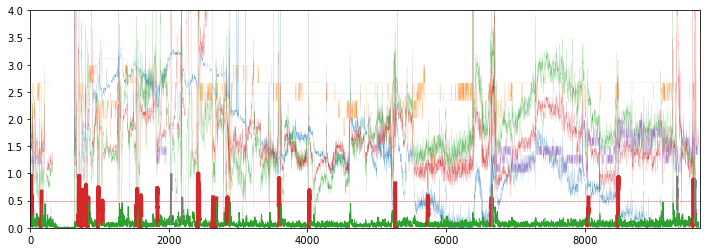

In [98]:
# Extract the time series, including missing data
observations = stay[columns].as_matrix()

# Normalize the time series
observations = (observations - scale[0])/scale[1]

# Prime the tracking
t = 0
x0 = None
hprev = None
prevs = None
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(12)
fig.set_figheight(4)
ax.set_xlim((0, len(observations)))
ax.set_ylim((0, 4))
ax.axhline(0, ls='dashed', lw=0.5, c='black')
ax.axhline(0.5, ls='dashed', lw=0.5, c='tab:red')
ax.plot(observations + 2, lw=0.1)
closeup_times = []
alert_times = []
severities = []
while True:
    # Get the next episode
    episode = as_batch(observations[t:t + WINDOW])
    t += len(episode)
    # Compute prediction for the next episode
    preds, h = track_episode(model, episode, WINDOW, x0, hprev)

    x0 = preds[-1, :, 0]  # first of last step, to chain episodes
    if t == len(observations):
        break
    if prevs is not None:
        kls = models.compute_kls(
                  torch.cat([prevs[-HORIZON:, :, HORIZON - 1],
                             preds[:-HORIZON, :, HORIZON - 1]], dim=0),
                  prevs[:, :, -1])
        window_severities = sigmoid(kls.data[:, 0].mean(dim=1).numpy())
        severities.extend(window_severities)
        color = 'tab:green'
        lw = 1
        max_severity = window_severities.max()
        if max_severity >= CLOSEUP_THRESHOLD:
            print("time: {} severity: {:.4f}"
                  .format(stay.index[0] + pandas.Timedelta("{} minutes".format(t)),
                          max_severity),
                  end=" ")
            closeup_times.append(t)
            closeup = torch.cat([hprev[-1, 0], h[-1, 0]], dim=0)
            if alert_model(closeup).data[0] >= ALERT_THRESHOLD:
                alert_times.append(t)
                color = 'tab:red'
                lw = 4
                print("+")
            else:
                color = 'tab:gray'
                lw = 2
                print("-")
        ax.plot(range(t - WINDOW, t), window_severities, c=color, lw=lw)
        
        if INCREMENTAL_DISPLAY:
            display.display(fig)
            display.clear_output(wait=True)
        else:
            print("{:06d}/{:06d}".format(t, len(observations)), end="\r")
    prevs = preds
    hprev = h

In [99]:
fig.savefig("../figures/kl-{}.pdf".format(STAYID))

## Componentwise changepoint detection with BOCD

In [100]:
LAMBDA = 360
ALPHA = 1
BETA = 1
KAPPA = 1.
MU = 0.
DELAY = 15
THRESHOLD = 0.5
series = observations[:, 0]
detector = bocd.BOCD(partial(bocd.constant_hazard, LAMBDA), 
                     bocd.StudentT(ALPHA, BETA, KAPPA, MU)) 
changepoints = []
xlast = 0.
for x in series[:DELAY]:
    if numpy.isnan(x):
        x = xlast
    xlast = x
    detector.update(x)
for x in series[DELAY:]:
    if numpy.isnan(x):
        x = xlast
    xlast = x
    detector.update(x)
    p = detector.growth_probs[DELAY]
    if p >= THRESHOLD:
        t = detector.t - DELAY + 1
        print("t: {} time: {} probability: {:.4f}"
                  .format(t,
                          stay.index[0] + pandas.Timedelta("{} minutes".format(t)),
                          p))
    changepoints.append(p)

t: 633 time: 2013-02-21 07:49:00 probability: 0.9338
t: 650 time: 2013-02-21 08:06:00 probability: 0.6546
t: 2183 time: 2013-02-22 09:39:00 probability: 0.7534
t: 2421 time: 2013-02-22 13:37:00 probability: 0.5171
t: 2883 time: 2013-02-22 21:19:00 probability: 0.8821
t: 2974 time: 2013-02-22 22:50:00 probability: 0.6131
t: 3008 time: 2013-02-22 23:24:00 probability: 0.8890
t: 3110 time: 2013-02-23 01:06:00 probability: 0.7893
t: 3505 time: 2013-02-23 07:41:00 probability: 0.7809
t: 3615 time: 2013-02-23 09:31:00 probability: 0.7422
t: 5214 time: 2013-02-24 12:10:00 probability: 0.5121
t: 5241 time: 2013-02-24 12:37:00 probability: 0.5937
t: 7285 time: 2013-02-25 22:41:00 probability: 0.6228
t: 9091 time: 2013-02-27 04:47:00 probability: 0.7511


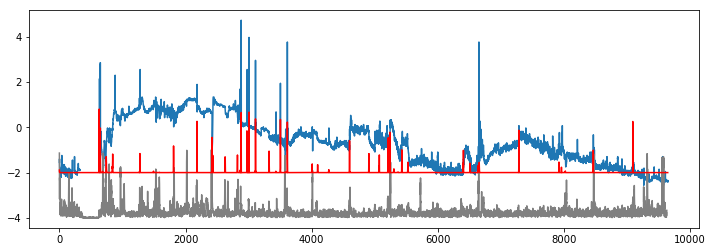

In [101]:
fig, ax = plt.subplots(1, 1, figsize=[12, 4])
ax.plot(series)
ax.plot([x*3 - 4 for x in severities], color='gray')
ax.plot([p*3 - 2 for p in changepoints], color='red')

## Existing tags

In [102]:
STAYS = "../data/stay_tags.pkl"
with open(STAYS, "rb") as f:
    stays = pickle.load(f)

if STAYID in stays:
    deterioration_tags = [tag for tag in stays[STAYID] if 'deterioration' in tag['concept']]
    print("{} has {} deterioration tags".format(STAYID, len(deterioration_tags)))
else:
    print("no deterioration tags in {}".format(STAYID))

Ichilov_MICU_20194 has 8 deterioration tags


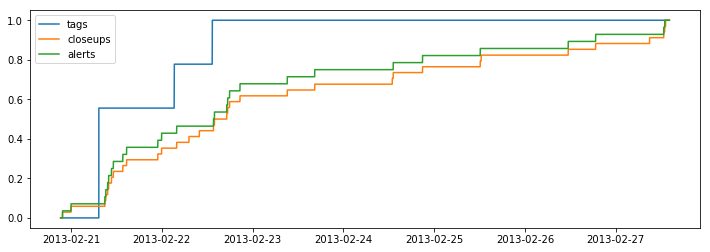

In [103]:
tag_times = sorted(set([tag['time'] for tag in deterioration_tags]))

tags = pandas.DataFrame({'time': tag_times,
                         'tag': [1] * len(tag_times)})
tags['time'] = pandas.to_datetime(tags['time'])
tags = tags.set_index('time')
tags = tags.reindex(stay.index, fill_value=0)

tags['closeup'] = 0
tags['closeup'][closeup_times] = 1
tags['alert'] = 0
tags['alert'][alert_times] = 1

fig, ax = plt.subplots(1, 1)
fig.set_figwidth(12)

ax.plot(tags['tag'].cumsum()/tags['tag'].sum(), label='tags')
ax.plot(tags['closeup'].cumsum()/tags['closeup'].sum(), label='closeups')
ax.plot(tags['alert'].cumsum()/tags['alert'].sum(), label='alerts')
ax.legend()

In [15]:
fig.savefig("../figures/tca-{}.pdf".format(STAYID))